# MC030 - Projeto final de Graduação
## Análise e Previsão do Mercado de Ações

## Descrição do modelo

A partir de um conjunto de cotações diárias de dólar para real (USD-BRL) desejamos modelar esse comportamento a partir de uma série de indicadores de mercado financeiro para classificarmos cada dia como um momento de compra ou momento de venda.

# ...

# Código

### Definindo endpoints da API (https://www.alphavantage.co/documentation/)

In [4]:
apiToken = '3GX5M109KQK9B6HO'
baseUrl = 'https://www.alphavantage.co/query?&outputsize=full&apikey=' + apiToken
usdBrlUrl = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=BRL&outputsize=full&apikey=' + apiToken
stockUrl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey=demo'

### Obtendo dados da API

In [5]:
import requests
import json
import time
callsMade = 0
def incrementAndVerifyCallsMade():
    global callsMade
    if callsMade == 5:
        print('Made 5 requests to the API in the last minute - sleeping for 1 minute')
        time.sleep(65)
        callsMade = 0
    callsMade += 1
def parsePriceRetrieved(stocksRetrieved):
    stockPrices = {}
    for date, candle in stocksRetrieved.items():
        stockPrices[date] = candle['1. open']
    return stockPrices
def parseIndicatorRetrieved(indicatorsRetrieved):
    indicatorValues = {}
    for date, indicator in indicatorsRetrieved.items():
        for indicatorSymbol, indicatorValue in indicator.items():
            if indicatorSymbol == 'Chaikin A/D':
                indicatorSymbol = 'AD'
            elif indicatorSymbol == 'MACD_Signal' || indicatorSymbol == 'MACD_Hist':
                continue
            indicatorValues[date] = {indicatorSymbol: indicatorValue}
    return indicatorValues
# returns [{date: price}]
def getStockPrice(stockSymbol):
    stockUrl = baseUrl + '&function=TIME_SERIES_DAILY&symbol=' + stockSymbol
    print('Fetching ' + stockUrl)
    incrementAndVerifyCallsMade()
    stocksRetrieved = requests.get(stockUrl).json();
    stocks = parsePriceRetrieved(stocksRetrieved['Time Series (Daily)'])
    print('Retrieved and parsed '+ stockUrl)
    return stocks
# returns [{date: price}]
def getForexPrice(fromSymbol, toSymbol):
    forexUrl = baseUrl + '&function=FX_DAILY&from_symbol=' + fromSymbol + '&to_symbol=' + toSymbol
    print('Fetching ' + forexUrl)
    incrementAndVerifyCallsMade()
    forexRetrieved = requests.get(forexUrl).json();
    forex = parsePriceRetrieved(forexRetrieved)
    print('Retrieved and parsed '+ forexUrl)
    return forex
# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicator(indicatorFunction, symbol):
    indicatorUrl = baseUrl + '&interval=daily&series_type=open&function=' + indicatorFunction + '&symbol=' + symbol
    if indicatorFunction=='SMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='EMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='WMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='DEMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='TEMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='TRIMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='KAMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='MAMA':
        indicatorUrl += '&fastlimit=0.01&slowlimit=0.01'
    elif indicatorFunction=='T3':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='MACD':
        indicatorUrl += '&fastperiod=12&slowperiod=26&signalperiod=9'
    elif indicatorFunction=='MACDEXT':
        indicatorUrl += '&fastperiod=12&slowperiod=26&signalperiod=9&fastmatype=0&slowmatype=0&signalmatype=0'
    elif indicatorFunction=='STOCH':
        indicatorUrl += '&fastkperiod=5&slowkperiod=3&slowdperiod=3&slowkmatype=0&slowdmatype=0'
    elif indicatorFunction=='STOCHF':
        indicatorUrl += '&fastkperiod=5&fastdperiod=3&fastdmatype=0'
    elif indicatorFunction=='RSI':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='STOCHRSI':
        indicatorUrl += '&time_period=10&fastkperiod=5&fastdperiod=3&fastdmatype=0'
    elif indicatorFunction=='WILLR':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='ADX':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='ADXR':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='APO':
        indicatorUrl += '&fastperiod=12&slowperiod=26&matype=0'
    elif indicatorFunction=='PPO':
        indicatorUrl += '&fastperiod=12&slowperiod=26&matype=0'
    elif indicatorFunction=='MOM':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='BOP':
        indicatorUrl += ''
    elif indicatorFunction=='CCI':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='CMO':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='CCI':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='ROC':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='ROCR':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='AROON':
        indicatorUrl += '&time_period=14'
    elif indicatorFunction=='AROONOSC':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='MFI':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='TRIX':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='ULTOSC':
        indicatorUrl += '&timeperiod1=7&timeperiod2=14&timeperiod3=28'
    elif indicatorFunction=='DX':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='AD':
        indicatorUrl += ''
        indicatorFunction = 'Chaikin A/D'
    elif indicatorFunction=='OBV':
        indicatorUrl += ''
    # TODO: terminar isso aqi
    print('Fetching ' + indicatorUrl)
    incrementAndVerifyCallsMade();
    indicatorRetrieved = requests.get(indicatorUrl).json()
    indicators = parseIndicatorRetrieved(indicatorRetrieved['Technical Analysis: ' + indicatorFunction])
    print('Retrieved and parsed '+ indicatorUrl)
    return indicators
# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicatorList(indicatorFunctions, symbol):
    indicators = {}
    for indicatorFunction in indicatorFunctions:
        indicatorDict = getIndicator(indicatorFunction, symbol)
        for date, indicator in indicatorDict.items():
            for indicatorFunction, indicatorValue in indicator.items():
                if  date not in indicators:
                    indicators[date] = {}
                indicators[date][indicatorFunction] = indicatorValue
    return indicators

In [6]:
# Filtrando dados válidos - apenas aqueles cujas datas estão na lista de preços e de indicadores
def filterData(prices, indicators, indicatorFunctions):
    filteredPrices = {date: price for date, price in prices.items() if date in indicators.keys()}
    filteredIndicators = {date: indicators for date, indicators in indicators.items() if date in prices.keys()}
    return filteredPrices, filteredIndicators

def getData(stockSymbol, indicatorFunctions):
    stockPrices = getStockPrice(stockSymbol)
    indicators = getIndicatorList(indicatorFunctions, stockSymbol)
    stockPrices, indicators = filterData(stockPrices, indicators, indicatorFunctions)
    return stockPrices, indicators

def getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions):
    forexPrices = getForexPrice(fromForexSymbol, toForexSymbol)
    indicators = getIndicatorList(indicatorFunctions, fromForexSymbol + toForexSymbol)
    forexPrices, indicators = filterData(forexPrices, indicators)
    return forexPrices, indicators

### Métodos de anotação de dados

In [145]:
import collections

def annotateBuyOrSellTwoClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'B'
            last = 'B'
        elif float(price) < yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'S'
            last = 'S'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateBuyOrSellEightClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.005:
            dateAnnotated[yesterdayDate] = 'B0'
            last = 'B0'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.01:
            dateAnnotated[yesterdayDate] = 'B1'
            last = 'B1'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.02:
            dateAnnotated[yesterdayDate] = 'B2'
            last = 'B2'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice > 1.02:
            dateAnnotated[yesterdayDate] = 'B3'
            last = 'B3'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .995:
            dateAnnotated[yesterdayDate] = 'S0'
            last = 'S0'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .99:
            dateAnnotated[yesterdayDate] = 'S1'
            last = 'S1'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .98:
            dateAnnotated[yesterdayDate] = 'S2'
            last = 'S2'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice < .98:
            dateAnnotated[yesterdayDate] = 'S3'
            last = 'S3'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateMaxProfit(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    yesterdayPrice = 0
    currentStatus = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice and currentStatus != 'B':
            dateAnnotated[yesterdayDate] = 'B'
            currentStatus = 'B'
        elif price < yesterdayPrice and currentStatus != 'S':
            dateAnnotated[yesterdayDate] = 'S'
            currentStatus = 'S'
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

### Normalização dos dados

In [121]:
# Dúvida - como faremos a normalização?
# Ideia: normalizarmos de acordo com o preço da ação no momento

# Exemplo: temos o valor de uma ação atualmente em R$3.00, mas sua média dos últimos 10 dias é de R$2.90,
# logo esta ação está aumentando de valor. Se normalizarmos todos os indicadores de acordo com o preço atual
# da ação podemos ter mais sucesso, pois no momento de atuação do modelo tudo que ele terá acesso será o preço 
# atual da ação e seus indicadores... Normalizar de acordo com um teto e piso de valores acho que pode dar ruim.

import copy

# Normaliza um conjunto de indicadores a partir do preço da ação
def normalizeIndicators(indicatorSet, stockPrice):
    normalizedIndicatorSet = {}
    for indicatorFunction, indicatorValue in indicatorSet.items():
        normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stockPrice)
    return normalizedIndicatorSet

# Retorna os indicadores normalizados: indicadores = [date: {indicators: ['SMA': 0.89, 'EMA': 0.93], annotation: 'B'}]
def getIndicatorsNormalizedAndAnnotaded(stockPrices, indicators, dateAnnotated):
    print('Normalizing and annotating indicators')
    indicatorsAnnotated = {}
    for date, annotation in dateAnnotated.items():
        if date not in indicatorsAnnotated:
            indicatorsAnnotated[date] = {'indicators': {}, 'annotation': ''}
        indicatorsAnnotated[date]['indicators'] = normalizeIndicators(indicators[date], stockPrices[date])
        indicatorsAnnotated[date]['annotation'] = annotation
    return indicatorsAnnotated

# Deprecated
def normalizeIndicatorsOld(indicatorsAnnotated):
    normalizedIndicators = {'B': [], 'S': []}
    for indicatorSet in indicatorsAnnotated['B']:
        normalizedIndicatorSet = []
        for indicator, value in indicatorSet.items():
            print(indicator)
            normalizedIndicatorSet.append({indicator: value/1000})
        normalizedIndicators[B].append(normalizedIndicatorSet)
    for indicators in indicatorsAnnotated['S']:
        print(indicators)

### Machine Learning

In [360]:
import keras
adam = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)

def getModelMLP(n_steps, n_features, n_outputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(64, activation='relu', input_shape=(n_steps*n_features,)))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelBidirectionalLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation='relu'), input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelCNN(n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation='relu'))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

### Análise de dados

In [112]:
def analyze(analytics):
    print('some analytics')

### Main

In [113]:
# Cheat-sheet com os simbolos
__indicatorSymbols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA',
                      'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 
                      'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR',
                      'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI',
                      'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'SAR', 'TRANGE', 'ATR',
                      'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE',
                      'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
__forexSymbols = ['BRL', 'EUR']
__stockSymbols = ['MSFT']

# Definindo simbolos para o modelo
indicatorFunctions = ['SMA', 'EMA', 'WMA']
# fromForexSymbol = 'USD'
# toForexSymbol = 'BRL'
stockSymbol = 'MSFT'

stockPrices, indicators = getData(stockSymbol, indicatorFunctions)
# forexPrices, indicators = getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions)
# dateAnnotated = annotateMaxProfit(stockPrices)

Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY&symbol=MSFT
Retrieved and parsed https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY&symbol=MSFT
Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=SMA&symbol=MSFT&time_period=10
Retrieved and parsed https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=SMA&symbol=MSFT&time_period=10
Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=EMA&symbol=MSFT&time_period=10
Made 5 requests to the API in the last minute - sleeping for 1 minute
Retrieved and parsed https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=EMA&symbol=MSFT&time_period=10
Fetching https://www.alp

In [139]:
df = pd.DataFrame.from_dict(stockPrices, orient='index')

div = df[0].astype('float').div(df[0].astype('float').shift(-1))

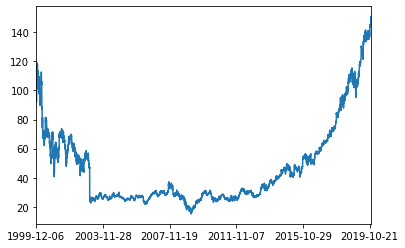

In [140]:
df.sort_index(inplace=True)
df[0].astype('float').plot()

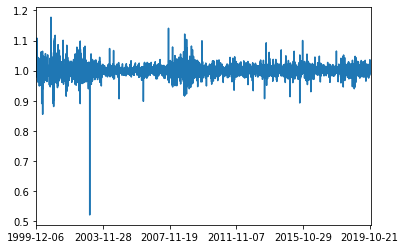

In [141]:
div.sort_index(inplace=True)
div.plot()

In [142]:
div.describe(percentiles=[.01,.1,.25,.5,.75,.9,.95,.99])

count    5023.000000
mean        1.000294
std         0.019655
min         0.521058
1%          0.951059
10%         0.981563
25%         0.991775
50%         1.000357
75%         1.008583
90%         1.019582
95%         1.027347
99%         1.053370
max         1.177592
Name: 0, dtype: float64

In [148]:
dateAnnotatedTwo = annotateBuyOrSellTwoClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotatedTwo, orient='index')
df[0].value_counts()

S    2567
B    2456
Name: 0, dtype: int64

In [149]:
dateAnnotatedEight = annotateBuyOrSellEightClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotatedEight, orient='index')
df[0].value_counts()

S0    835
B0    782
S2    641
S1    624
B2    612
B1    603
S3    467
B3    459
Name: 0, dtype: int64

In [156]:
import pandas as pd

normalizedIndicatorsTwo = getIndicatorsNormalizedAndAnnotaded(stockPrices, indicators, dateAnnotatedTwo)
normalizedIndicatorsEight = getIndicatorsNormalizedAndAnnotaded(stockPrices, indicators, dateAnnotatedEight)

dataTwo = pd.DataFrame.from_dict(normalizedIndicatorsTwo, orient='index')
dataEight = pd.DataFrame.from_dict(normalizedIndicatorsEight, orient='index')

Normalizing and annotating indicators
Normalizing and annotating indicators


In [157]:
dataTwo = pd.DataFrame.merge(pd.DataFrame(dataTwo.indicators.values.tolist(), index=dataTwo.index), dataTwo, left_index=True, right_index=True, how='outer').drop(columns=['indicators'])
dataEight = pd.DataFrame.merge(pd.DataFrame(dataEight.indicators.values.tolist(), index=dataEight.index), dataEight, left_index=True, right_index=True, how='outer').drop(columns=['indicators'])

In [158]:
dataTwo.head(), dataEight.head()

(                 SMA       EMA       WMA annotation
 2019-11-21  0.989926  0.991931  0.997135          B
 2019-11-20  0.980234  0.984143  0.988606          B
 2019-11-19  0.972594  0.976915  0.980575          S
 2019-11-18  0.973906  0.977031  0.980141          S
 2019-11-15  0.977842  0.979366  0.982223          S,
                  SMA       EMA       WMA annotation
 2019-11-21  0.989926  0.991931  0.997135         B1
 2019-11-20  0.980234  0.984143  0.988606         B0
 2019-11-19  0.972594  0.976915  0.980575         S1
 2019-11-18  0.973906  0.977031  0.980141         S1
 2019-11-15  0.977842  0.979366  0.982223         S2)

In [159]:
dataTwo.annotation = dataTwo.annotation.apply(lambda x: 0 if x == 'S' else 1)

eight_dict = {"B3":0, "B2": 1, "B1": 2, "B0": 3, "S0": 4, "S1": 5, "S2": 6, "S3": 7}
dataEight.annotation = dataEight.annotation.apply(lambda x: eight_dict[x])

In [160]:
dataTwo = dataTwo.sort_index()
dataEight = dataEight.sort_index()

In [327]:
import numpy as np
import matplotlib.pyplot as plt

n_steps = 4
n_indicators = 3

batch_size = 32
train_test_split = .8

X = {
    "mlp": {
        2 : [],
        8 : [] 
    },
    "lstm": {
        2 : [],
        8 : []
    }
}
y = {
    2 : [],
    8 : [] 
}

for i in range(len(dataTwo)):
    end_ix = i + n_steps
    if end_ix > len(dataTwo):
        break
    seq_x, seq_y = dataTwo.iloc[i:end_ix, :-1].values, dataTwo.iloc[end_ix-1, -1]
    X["lstm"][2].append(seq_x)
    X["mlp"][2].append(seq_x.flatten())
    y[2].append(seq_y)
    
for i in range(len(dataEight)):
    end_ix = i + n_steps
    if end_ix > len(dataEight):
        break
    seq_x, seq_y = dataEight.iloc[i:end_ix, :-1].values, dataEight.iloc[end_ix-1, -1]
    X["lstm"][8].append(seq_x)
    X["mlp"][8].append(seq_x.flatten())
    y[8].append(np.eye(8)[seq_y])

X["lstm"][2] = np.array(X["lstm"][2])
X["mlp"][2] = np.array(X["mlp"][2])
y[2] = np.array(y[2])

X["lstm"][8] = np.array(X["lstm"][8])
X["mlp"][8] = np.array(X["mlp"][8])
y[8] = np.array(y[8])

In [328]:
dataTwo.head()

,SMA,EMA,WMA,annotation
1999-12-07,0.971239,0.972042,0.982787,1
1999-12-08,0.992348,0.991003,1.002084,1
1999-12-09,1.007132,1.002554,1.013524,1
1999-12-10,0.994175,0.990011,0.999999,0
1999-12-13,0.995412,0.989802,0.999010,0


In [329]:
X["lstm"][2][0]

array([[0.97123905, 0.97204222, 0.98278734],
       [0.99234792, 0.99100349, 1.0020843 ],
       [1.00713152, 1.00255435, 1.01352391],
       [0.9941751 , 0.99001124, 0.99999893]])

In [330]:
X["mlp"][2][0]

array([0.97123905, 0.97204222, 0.98278734, 0.99234792, 0.99100349,
       1.0020843 , 1.00713152, 1.00255435, 1.01352391, 0.9941751 ,
       0.99001124, 0.99999893])

In [331]:
len(X["lstm"][2])

5020

In [332]:
from sklearn.model_selection import train_test_split

X_train = {
    "mlp": {
    },
    "lstm": {
        2 : X["lstm"][2][:int(len(X["lstm"][2]) * train_test_split)],
        8 : X["lstm"][8][:int(len(X["lstm"][8]) * train_test_split)]
    }
}

X_val = {
    "mlp": {
    },
    "lstm": {
        2 : X["lstm"][2][int(len(X["lstm"][2]) * train_test_split):],
        8 : X["lstm"][8][int(len(X["lstm"][8]) * train_test_split):]
    }
}

y_train = {
    "mlp": {
    },
    "lstm": {
        2 : y[2][:int(len(y[2]) * train_test_split)],
        8 : y[8][:int(len(y[8]) * train_test_split)] 
    }
}

y_val = {
    "mlp": {
    },
    "lstm": {
        2 : y[2][int(len(y[2]) * train_test_split):],
        8 : y[8][int(len(y[2]) * train_test_split):] 
    }
}


X_train["mlp"][2], X_val["mlp"][2], y_train["mlp"][2], y_val["mlp"][2] = 
X_train["mlp"][8], X_val["mlp"][8], y_train["mlp"][2], y_val["mlp"][2] = 

len(X_train["mlp"][2]), len(y_train[2]), len(X_train["lstm"][8]), len(y_val[8]) 

(4016, 4016, 4016, 1004)

In [314]:
print(X_train["lstm"][2].shape, y_train[2].shape)
for i in range(len(X_train["mlp"][2])):
    print(X_train["lstm"][2][i], y_train[2][i])

(4016, 4, 3) (4016,)
[[0.97123905 0.97204222 0.98278734]
 [0.99234792 0.99100349 1.0020843 ]
 [1.00713152 1.00255435 1.01352391]
 [0.9941751  0.99001124 0.99999893]] 0
[[0.99234792 0.99100349 1.0020843 ]
 [1.00713152 1.00255435 1.01352391]
 [0.9941751  0.99001124 0.99999893]
 [0.99541177 0.98980226 0.99900971]] 0
[[1.00713152 1.00255435 1.01352391]
 [0.9941751  0.99001124 0.99999893]
 [0.99541177 0.98980226 0.99900971]
 [0.97541585 0.96994324 0.97791097]] 0
[[0.9941751  0.99001124 0.99999893]
 [0.99541177 0.98980226 0.99900971]
 [0.97541585 0.96994324 0.97791097]
 [0.95952132 0.95628481 0.96309061]] 0
[[0.99541177 0.98980226 0.99900971]
 [0.97541585 0.96994324 0.97791097]
 [0.95952132 0.95628481 0.96309061]
 [0.88047872 0.88769611 0.89330526]] 0
[[0.97541585 0.96994324 0.97791097]
 [0.95952132 0.95628481 0.96309061]
 [0.88047872 0.88769611 0.89330526]
 [0.84264523 0.8621865  0.86866967]] 0
[[0.95952132 0.95628481 0.96309061]
 [0.88047872 0.88769611 0.89330526]
 [0.84264523 0.8621865  0

[[0.96975485 0.97498421 0.97211611]
 [0.95382465 0.96204766 0.96017211]
 [0.95634897 0.96640909 0.96603079]
 [0.96972749 0.98047986 0.98194461]] 1
[[0.95382465 0.96204766 0.96017211]
 [0.95634897 0.96640909 0.96603079]
 [0.96972749 0.98047986 0.98194461]
 [0.97196275 0.9823692  0.98578185]] 0
[[0.95634897 0.96640909 0.96603079]
 [0.96972749 0.98047986 0.98194461]
 [0.97196275 0.9823692  0.98578185]
 [0.98513996 0.99155896 0.99690292]] 1
[[0.96972749 0.98047986 0.98194461]
 [0.97196275 0.9823692  0.98578185]
 [0.98513996 0.99155896 0.99690292]
 [0.9915537  0.99345598 0.99997021]] 1
[[0.97196275 0.9823692  0.98578185]
 [0.98513996 0.99155896 0.99690292]
 [0.9915537  0.99345598 0.99997021]
 [1.01028476 1.00831112 1.01528779]] 1
[[0.98513996 0.99155896 0.99690292]
 [0.9915537  0.99345598 0.99997021]
 [1.01028476 1.00831112 1.01528779]
 [0.9979604  0.99267679 0.99917969]] 0
[[0.9915537  0.99345598 0.99997021]
 [1.01028476 1.00831112 1.01528779]
 [0.9979604  0.99267679 0.99917969]
 [0.978308

[[1.00842431 1.00541849 1.01528748]
 [0.98352133 0.97862883 0.98765597]
 [0.98815558 0.98138684 0.98951426]
 [0.98078929 0.975      0.98181154]] 0
[[0.98352133 0.97862883 0.98765597]
 [0.98815558 0.98138684 0.98951426]
 [0.98078929 0.975      0.98181154]
 [0.99145314 0.98710425 0.99292032]] 1
[[0.98815558 0.98138684 0.98951426]
 [0.98078929 0.975      0.98181154]
 [0.99145314 0.98710425 0.99292032]
 [0.95428427 0.9549832  0.95979503]] 0
[[0.98078929 0.975      0.98181154]
 [0.99145314 0.98710425 0.99292032]
 [0.95428427 0.9549832  0.95979503]
 [0.96970058 0.97300442 0.97800272]] 1
[[0.99145314 0.98710425 0.99292032]
 [0.95428427 0.9549832  0.95979503]
 [0.96970058 0.97300442 0.97800272]
 [0.9803228  0.98529533 0.9909478 ]] 1
[[0.95428427 0.9549832  0.95979503]
 [0.96970058 0.97300442 0.97800272]
 [0.9803228  0.98529533 0.9909478 ]
 [0.969436   0.97462682 0.98107396]] 0
[[0.96970058 0.97300442 0.97800272]
 [0.9803228  0.98529533 0.9909478 ]
 [0.969436   0.97462682 0.98107396]
 [1.011099

 [0.98372572 0.98892385 0.99052836]] 1
[[0.97922718 0.98186796 0.98213204]
 [0.97643354 0.98112828 0.98187017]
 [0.98372572 0.98892385 0.99052836]
 [0.98438372 0.98905814 0.99160078]] 0
[[0.97643354 0.98112828 0.98187017]
 [0.98372572 0.98892385 0.99052836]
 [0.98438372 0.98905814 0.99160078]
 [0.99200978 0.99478222 0.99819324]] 1
[[0.98372572 0.98892385 0.99052836]
 [0.98438372 0.98905814 0.99160078]
 [0.99200978 0.99478222 0.99819324]
 [0.99289709 0.99356505 0.99746796]] 0
[[0.98438372 0.98905814 0.99160078]
 [0.99200978 0.99478222 0.99819324]
 [0.99289709 0.99356505 0.99746796]
 [0.99294981 0.99224518 0.99625616]] 0
[[0.99200978 0.99478222 0.99819324]
 [0.99289709 0.99356505 0.99746796]
 [0.99294981 0.99224518 0.99625616]
 [0.98972682 0.98863024 0.99248942]] 0
[[0.99289709 0.99356505 0.99746796]
 [0.99294981 0.99224518 0.99625616]
 [0.98972682 0.98863024 0.99248942]
 [1.00136028 0.99886902 1.0025651 ]] 1
[[0.99294981 0.99224518 0.99625616]
 [0.98972682 0.98863024 0.99248942]
 [1.001

 [0.9909699  0.99044221 0.99724266]] 0
[[0.98501677 0.98948938 0.99529631]
 [0.99089892 0.99200671 0.99863111]
 [0.9909699  0.99044221 0.99724266]
 [0.98619472 0.98418942 0.99082714]] 0
[[0.99089892 0.99200671 0.99863111]
 [0.9909699  0.99044221 0.99724266]
 [0.98619472 0.98418942 0.99082714]
 [0.98109938 0.97850382 0.98471059]] 0
[[0.9909699  0.99044221 0.99724266]
 [0.98619472 0.98418942 0.99082714]
 [0.98109938 0.97850382 0.98471059]
 [0.98821938 0.98592687 0.99168556]] 1
[[0.98619472 0.98418942 0.99082714]
 [0.98109938 0.97850382 0.98471059]
 [0.98821938 0.98592687 0.99168556]
 [0.99142753 0.98937042 0.99471816]] 1
[[0.98109938 0.97850382 0.98471059]
 [0.98821938 0.98592687 0.99168556]
 [0.99142753 0.98937042 0.99471816]
 [0.99191816 0.98982463 0.99478992]] 0
[[0.98821938 0.98592687 0.99168556]
 [0.99142753 0.98937042 0.99471816]
 [0.99191816 0.98982463 0.99478992]
 [0.99258123 0.99108434 0.9956663 ]] 0
[[0.99142753 0.98937042 0.99471816]
 [0.99191816 0.98982463 0.99478992]
 [0.992

 [1.01611481 1.01598519 1.0165037 ]] 1
[[0.99351879 0.99338873 0.99366691]
 [0.99364179 0.99502982 0.99528646]
 [1.01611481 1.01598519 1.0165037 ]
 [1.023367   1.02147774 1.02197531]] 1
[[0.99364179 0.99502982 0.99528646]
 [1.01611481 1.01598519 1.0165037 ]
 [1.023367   1.02147774 1.02197531]
 [1.0467768  1.0400461  1.04020745]] 1
[[1.01611481 1.01598519 1.0165037 ]
 [1.023367   1.02147774 1.02197531]
 [1.0467768  1.0400461  1.04020745]
 [1.0356963  1.02692102 1.02586417]] 0
[[1.023367   1.02147774 1.02197531]
 [1.0467768  1.0400461  1.04020745]
 [1.0356963  1.02692102 1.02586417]
 [1.03070992 1.02234733 1.01969466]] 1
[[1.0467768  1.0400461  1.04020745]
 [1.0356963  1.02692102 1.02586417]
 [1.03070992 1.02234733 1.01969466]
 [1.01427602 1.00819005 1.00406863]] 0
[[1.0356963  1.02692102 1.02586417]
 [1.03070992 1.02234733 1.01969466]
 [1.01427602 1.00819005 1.00406863]
 [1.02584674 1.01997701 1.01466284]] 1
[[1.03070992 1.02234733 1.01969466]
 [1.01427602 1.00819005 1.00406863]
 [1.025

 [0.96389651 0.97717758 0.97889063]] 0
[[0.94615686 0.96637255 0.96119216]
 [0.95478431 0.97248627 0.97098039]
 [0.96389651 0.97717758 0.97889063]
 [0.99154647 0.99894231 1.00316106]] 1
[[0.95478431 0.97248627 0.97098039]
 [0.96389651 0.97717758 0.97889063]
 [0.99154647 0.99894231 1.00316106]
 [1.00020113 1.00242156 1.00800885]] 1
[[0.96389651 0.97717758 0.97889063]
 [0.99154647 0.99894231 1.00316106]
 [1.00020113 1.00242156 1.00800885]
 [0.97824219 0.97827344 0.98408984]] 0
[[0.99154647 0.99894231 1.00316106]
 [1.00020113 1.00242156 1.00800885]
 [0.97824219 0.97827344 0.98408984]
 [0.98526068 0.985049   0.99088985]] 1
[[1.00020113 1.00242156 1.00800885]
 [0.97824219 0.97827344 0.98408984]
 [0.98526068 0.985049   0.99088985]
 [0.97852167 0.97747291 0.98320433]] 0
[[0.97824219 0.97827344 0.98408984]
 [0.98526068 0.985049   0.99088985]
 [0.97852167 0.97747291 0.98320433]
 [0.98329466 0.98095128 0.98648492]] 0
[[0.98526068 0.985049   0.99088985]
 [0.97852167 0.97747291 0.98320433]
 [0.983

 [0.99933775 0.9979665  0.99910012]] 1
[[0.9964619  0.99459176 0.99633748]
 [0.99708398 0.99557543 0.99698289]
 [0.99933775 0.9979665  0.99910012]
 [0.98681783 0.98735204 0.98822444]] 0
[[0.99708398 0.99557543 0.99698289]
 [0.99933775 0.9979665  0.99910012]
 [0.98681783 0.98735204 0.98822444]
 [0.99311678 0.99464811 0.99562645]] 1
[[0.99933775 0.9979665  0.99910012]
 [0.98681783 0.98735204 0.98822444]
 [0.99311678 0.99464811 0.99562645]
 [0.98869666 0.99093041 0.99217609]] 0
[[0.98681783 0.98735204 0.98822444]
 [0.99311678 0.99464811 0.99562645]
 [0.98869666 0.99093041 0.99217609]
 [0.99728892 0.99854376 1.00021301]] 1
[[0.99311678 0.99464811 0.99562645]
 [0.98869666 0.99093041 0.99217609]
 [0.99728892 0.99854376 1.00021301]
 [0.99532999 0.99597067 0.99785797]] 0
[[0.98869666 0.99093041 0.99217609]
 [0.99728892 0.99854376 1.00021301]
 [0.99532999 0.99597067 0.99785797]
 [0.99557376 0.99517312 0.99717244]] 0
[[0.99728892 0.99854376 1.00021301]
 [0.99532999 0.99597067 0.99785797]
 [0.995

 [1.0198855  1.01591603 1.01673028]] 1
[[1.00944322 1.01026423 1.01106323]
 [1.00995592 1.00917821 1.01012909]
 [1.0198855  1.01591603 1.01673028]
 [1.01462196 1.00855109 1.00864283]] 0
[[1.00995592 1.00917821 1.01012909]
 [1.0198855  1.01591603 1.01673028]
 [1.01462196 1.00855109 1.00864283]
 [0.99632437 0.99225416 0.9912599 ]] 0
[[1.0198855  1.01591603 1.01673028]
 [1.01462196 1.00855109 1.00864283]
 [0.99632437 0.99225416 0.9912599 ]
 [0.91869565 0.92485511 0.92326833]] 0
[[1.01462196 1.00855109 1.00864283]
 [0.99632437 0.99225416 0.9912599 ]
 [0.91869565 0.92485511 0.92326833]
 [0.94477035 0.95535465 0.95487791]] 1
[[0.99632437 0.99225416 0.9912599 ]
 [0.91869565 0.92485511 0.92326833]
 [0.94477035 0.95535465 0.95487791]
 [0.97271371 0.98411159 0.98559749]] 1
[[0.91869565 0.92485511 0.92326833]
 [0.94477035 0.95535465 0.95487791]
 [0.97271371 0.98411159 0.98559749]
 [0.98009883 0.99001497 0.9935879 ]] 1
[[0.94477035 0.95535465 0.95487791]
 [0.97271371 0.98411159 0.98559749]
 [0.980

 [1.02925842 1.02401274 1.02025933]] 1
[[1.02796221 1.02162168 1.02020468]
 [1.02358813 1.01731565 1.01474595]
 [1.02925842 1.02401274 1.02025933]
 [1.01594948 1.0124673  1.00780108]] 0
[[1.02358813 1.01731565 1.01474595]
 [1.02925842 1.02401274 1.02025933]
 [1.01594948 1.0124673  1.00780108]
 [1.00986049 1.00833483 1.00304905]] 0
[[1.02925842 1.02401274 1.02025933]
 [1.01594948 1.0124673  1.00780108]
 [1.00986049 1.00833483 1.00304905]
 [1.00080447 1.00110615 0.99557989]] 0
[[1.01594948 1.0124673  1.00780108]
 [1.00986049 1.00833483 1.00304905]
 [1.00080447 1.00110615 0.99557989]
 [0.99275717 0.99617196 0.99073317]] 0
[[1.00986049 1.00833483 1.00304905]
 [1.00080447 1.00110615 0.99557989]
 [0.99275717 0.99617196 0.99073317]
 [0.99210825 0.99757622 0.99275311]] 1
[[1.00080447 1.00110615 0.99557989]
 [0.99275717 0.99617196 0.99073317]
 [0.99210825 0.99757622 0.99275311]
 [0.98255446 0.98941474 0.98562596]] 0
[[0.99275717 0.99617196 0.99073317]
 [0.99210825 0.99757622 0.99275311]
 [0.982

In [361]:
MLP_2 = getModelMLP(n_steps, n_indicators, 1)
MLP_8 = getModelMLP(n_steps, n_indicators, 8)

LSTM_2 = getModelBidirectionalLSTM(n_steps, n_indicators, 1)
LSTM_8 = getModelBidirectionalLSTM(n_steps, n_indicators, 8)

In [362]:
MLP_2, LSTM_2, MLP_8, LSTM_8

(<keras.engine.sequential.Sequential at 0x158bf8f10>,
 <keras.engine.sequential.Sequential at 0x157f0b410>)

In [363]:
MLP_2.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 64)                832       
_________________________________________________________________
dropout_57 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_58 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 1)                 65        
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________


In [364]:
MLP_8.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 64)                832       
_________________________________________________________________
dropout_59 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_60 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 8)                 520       
Total params: 5,512
Trainable params: 5,512
Non-trainable params: 0
_________________________________________________________________


In [365]:
LSTM_2.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_29 (Bidirectio (None, 128)               34816     
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 129       
Total params: 34,945
Trainable params: 34,945
Non-trainable params: 0
_________________________________________________________________


In [366]:
LSTM_8.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_30 (Bidirectio (None, 128)               34816     
_________________________________________________________________
dense_123 (Dense)            (None, 8)                 1032      
Total params: 35,848
Trainable params: 35,848
Non-trainable params: 0
_________________________________________________________________


Train on 4016 samples, validate on 1004 samples
Epoch 1/200
4016/4016 [==============================] - 0s 113us/step - loss: 0.6990 - accuracy: 0.5020 - val_loss: 0.6984 - val_accuracy: 0.4402
Epoch 2/200
4016/4016 [==============================] - 0s 47us/step - loss: 0.6948 - accuracy: 0.5157 - val_loss: 0.6889 - val_accuracy: 0.5598
Epoch 3/200
4016/4016 [==============================] - 0s 46us/step - loss: 0.6943 - accuracy: 0.5025 - val_loss: 0.6904 - val_accuracy: 0.7311
Epoch 4/200
4016/4016 [==============================] - 0s 46us/step - loss: 0.6907 - accuracy: 0.5222 - val_loss: 0.6917 - val_accuracy: 0.4572
Epoch 5/200
4016/4016 [==============================] - 0s 46us/step - loss: 0.6912 - accuracy: 0.5229 - val_loss: 0.6903 - val_accuracy: 0.6325
Epoch 6/200
4016/4016 [==============================] - 0s 46us/step - loss: 0.6901 - accuracy: 0.5311 - val_loss: 0.6955 - val_accuracy: 0.4402
Epoch 7/200
4016/4016 [==============================] - 0s 45us/step - los

4016/4016 [==============================] - 0s 46us/step - loss: 0.3468 - accuracy: 0.8449 - val_loss: 0.3864 - val_accuracy: 0.7699
Epoch 57/200
4016/4016 [==============================] - 0s 46us/step - loss: 0.3628 - accuracy: 0.8304 - val_loss: 0.3916 - val_accuracy: 0.7669
Epoch 58/200
4016/4016 [==============================] - 0s 47us/step - loss: 0.3220 - accuracy: 0.8623 - val_loss: 0.3706 - val_accuracy: 0.7839
Epoch 59/200
4016/4016 [==============================] - 0s 46us/step - loss: 0.3320 - accuracy: 0.8581 - val_loss: 0.2847 - val_accuracy: 0.9343
Epoch 60/200
4016/4016 [==============================] - 0s 50us/step - loss: 0.3499 - accuracy: 0.8394 - val_loss: 0.2833 - val_accuracy: 0.9422
Epoch 61/200
4016/4016 [==============================] - 0s 45us/step - loss: 0.3179 - accuracy: 0.8640 - val_loss: 0.2723 - val_accuracy: 0.9572
Epoch 62/200
4016/4016 [==============================] - 0s 44us/step - loss: 0.2992 - accuracy: 0.8745 - val_loss: 0.3047 - val_a

Epoch 112/200
4016/4016 [==============================] - 0s 46us/step - loss: 0.2637 - accuracy: 0.8897 - val_loss: 0.2541 - val_accuracy: 0.8865
Epoch 113/200
4016/4016 [==============================] - 0s 43us/step - loss: 0.2691 - accuracy: 0.8795 - val_loss: 0.2494 - val_accuracy: 0.9153
Epoch 114/200
4016/4016 [==============================] - 0s 43us/step - loss: 0.2761 - accuracy: 0.8780 - val_loss: 0.2445 - val_accuracy: 0.8875
Epoch 115/200
4016/4016 [==============================] - 0s 46us/step - loss: 0.2771 - accuracy: 0.8733 - val_loss: 0.2349 - val_accuracy: 0.9124
Epoch 116/200
4016/4016 [==============================] - 0s 44us/step - loss: 0.2698 - accuracy: 0.8787 - val_loss: 0.2346 - val_accuracy: 0.9104
Epoch 117/200
4016/4016 [==============================] - 0s 45us/step - loss: 0.2815 - accuracy: 0.8685 - val_loss: 0.1946 - val_accuracy: 0.9751
Epoch 118/200
4016/4016 [==============================] - 0s 45us/step - loss: 0.2894 - accuracy: 0.8705 - val_

4016/4016 [==============================] - 0s 44us/step - loss: 0.2826 - accuracy: 0.8750 - val_loss: 0.1913 - val_accuracy: 0.9592
Epoch 168/200
4016/4016 [==============================] - 0s 46us/step - loss: 0.2788 - accuracy: 0.8797 - val_loss: 0.2599 - val_accuracy: 0.8745
Epoch 169/200
4016/4016 [==============================] - 0s 53us/step - loss: 0.3115 - accuracy: 0.8673 - val_loss: 0.2682 - val_accuracy: 0.8536
Epoch 170/200
4016/4016 [==============================] - 0s 43us/step - loss: 0.3354 - accuracy: 0.8411 - val_loss: 0.1905 - val_accuracy: 0.9114
Epoch 171/200
4016/4016 [==============================] - 0s 45us/step - loss: 0.3054 - accuracy: 0.8593 - val_loss: 0.2923 - val_accuracy: 0.8496
Epoch 172/200
4016/4016 [==============================] - 0s 47us/step - loss: 0.3145 - accuracy: 0.8548 - val_loss: 0.2246 - val_accuracy: 0.9432
Epoch 173/200
4016/4016 [==============================] - 0s 57us/step - loss: 0.2718 - accuracy: 0.8772 - val_loss: 0.2279 -

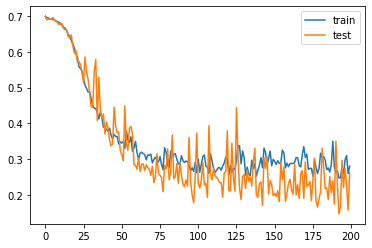

In [367]:
history_mlp_2 = MLP_2.fit(X_train["mlp"][2], y_train[2], epochs=300, verbose=1, validation_data=(X_val["mlp"][2],y_val[2]), batch_size=batch_size)
plt.plot(history_mlp_2.history['loss'], label='train')
plt.plot(history_mlp_2.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 4016 samples, validate on 1004 samples
Epoch 1/200
4016/4016 [==============================] - 0s 109us/step - loss: 2.0830 - accuracy: 0.1449 - val_loss: 2.0350 - val_accuracy: 0.1733
Epoch 2/200
4016/4016 [==============================] - 0s 51us/step - loss: 2.0730 - accuracy: 0.1559 - val_loss: 2.0469 - val_accuracy: 0.1733
Epoch 3/200
4016/4016 [==============================] - 0s 47us/step - loss: 2.0730 - accuracy: 0.1509 - val_loss: 2.0497 - val_accuracy: 0.1733
Epoch 4/200
4016/4016 [==============================] - 0s 53us/step - loss: 2.0715 - accuracy: 0.1531 - val_loss: 2.0479 - val_accuracy: 0.2191
Epoch 5/200
4016/4016 [==============================] - 0s 52us/step - loss: 2.0700 - accuracy: 0.1526 - val_loss: 2.0408 - val_accuracy: 0.2221
Epoch 6/200
4016/4016 [==============================] - 0s 55us/step - loss: 2.0690 - accuracy: 0.1561 - val_loss: 2.0417 - val_accuracy: 0.1733
Epoch 7/200
4016/4016 [==============================] - 0s 57us/step - los

4016/4016 [==============================] - 0s 44us/step - loss: 1.6267 - accuracy: 0.3357 - val_loss: 1.5777 - val_accuracy: 0.4920
Epoch 57/200
4016/4016 [==============================] - 0s 43us/step - loss: 1.6260 - accuracy: 0.3531 - val_loss: 1.5512 - val_accuracy: 0.4651
Epoch 58/200
4016/4016 [==============================] - 0s 44us/step - loss: 1.6186 - accuracy: 0.3466 - val_loss: 1.6700 - val_accuracy: 0.2221
Epoch 59/200
4016/4016 [==============================] - 0s 45us/step - loss: 1.6202 - accuracy: 0.3439 - val_loss: 1.5372 - val_accuracy: 0.4871
Epoch 60/200
4016/4016 [==============================] - 0s 43us/step - loss: 1.5963 - accuracy: 0.3546 - val_loss: 1.5775 - val_accuracy: 0.3267
Epoch 61/200
4016/4016 [==============================] - 0s 43us/step - loss: 1.5960 - accuracy: 0.3491 - val_loss: 1.5253 - val_accuracy: 0.4343
Epoch 62/200
4016/4016 [==============================] - 0s 43us/step - loss: 1.5720 - accuracy: 0.3603 - val_loss: 1.5185 - val_a

Epoch 112/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.3256 - accuracy: 0.4410 - val_loss: 1.1457 - val_accuracy: 0.7231
Epoch 113/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.2960 - accuracy: 0.4522 - val_loss: 1.1433 - val_accuracy: 0.6633
Epoch 114/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.3119 - accuracy: 0.4457 - val_loss: 1.1740 - val_accuracy: 0.6145
Epoch 115/200
4016/4016 [==============================] - 0s 43us/step - loss: 1.2899 - accuracy: 0.4622 - val_loss: 1.1256 - val_accuracy: 0.7181
Epoch 116/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.2812 - accuracy: 0.4587 - val_loss: 1.1134 - val_accuracy: 0.7102
Epoch 117/200
4016/4016 [==============================] - 0s 44us/step - loss: 1.2802 - accuracy: 0.4636 - val_loss: 1.1822 - val_accuracy: 0.5020
Epoch 118/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.2652 - accuracy: 0.4768 - val_

4016/4016 [==============================] - 0s 42us/step - loss: 1.1832 - accuracy: 0.4985 - val_loss: 0.9795 - val_accuracy: 0.8038
Epoch 168/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.1532 - accuracy: 0.5117 - val_loss: 0.9402 - val_accuracy: 0.8207
Epoch 169/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.1530 - accuracy: 0.5232 - val_loss: 0.9179 - val_accuracy: 0.7829
Epoch 170/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.1578 - accuracy: 0.5082 - val_loss: 0.9567 - val_accuracy: 0.8088
Epoch 171/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.1440 - accuracy: 0.5266 - val_loss: 0.9627 - val_accuracy: 0.6255
Epoch 172/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.1455 - accuracy: 0.5229 - val_loss: 0.9689 - val_accuracy: 0.6753
Epoch 173/200
4016/4016 [==============================] - 0s 42us/step - loss: 1.1343 - accuracy: 0.5319 - val_loss: 0.9556 -

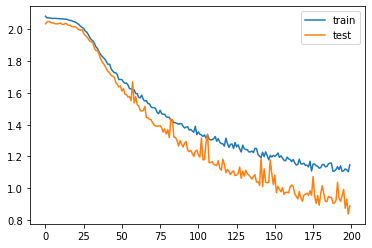

In [368]:
history_mlp_8 = MLP_8.fit(X_train["mlp"][8], y_train[8], epochs=300, verbose=1, validation_data=(X_val["mlp"][8],y_val[8]), batch_size=batch_size)
plt.plot(history_mlp_8.history['loss'], label='train')
plt.plot(history_mlp_8.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 4016 samples, validate on 1004 samples
Epoch 1/200
4016/4016 [==============================] - 2s 416us/step - loss: 0.6947 - accuracy: 0.4938 - val_loss: 0.6978 - val_accuracy: 0.4402
Epoch 2/200
4016/4016 [==============================] - 1s 162us/step - loss: 0.6937 - accuracy: 0.5047 - val_loss: 0.6972 - val_accuracy: 0.4402
Epoch 3/200
4016/4016 [==============================] - 1s 160us/step - loss: 0.6931 - accuracy: 0.5032 - val_loss: 0.6917 - val_accuracy: 0.5598
Epoch 4/200
4016/4016 [==============================] - 1s 161us/step - loss: 0.6933 - accuracy: 0.5075 - val_loss: 0.6948 - val_accuracy: 0.4402
Epoch 5/200
4016/4016 [==============================] - 1s 169us/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6920 - val_accuracy: 0.5598
Epoch 6/200
4016/4016 [==============================] - 1s 169us/step - loss: 0.6932 - accuracy: 0.5117 - val_loss: 0.6968 - val_accuracy: 0.4402
Epoch 7/200
4016/4016 [==============================] - 1s 161us/step

4016/4016 [==============================] - 1s 157us/step - loss: 0.4570 - accuracy: 0.8337 - val_loss: 0.4852 - val_accuracy: 0.8625
Epoch 57/200
4016/4016 [==============================] - 1s 158us/step - loss: 0.4665 - accuracy: 0.7971 - val_loss: 0.4850 - val_accuracy: 0.7171
Epoch 58/200
4016/4016 [==============================] - 1s 162us/step - loss: 0.4452 - accuracy: 0.8187 - val_loss: 0.4829 - val_accuracy: 0.7072
Epoch 59/200
4016/4016 [==============================] - 1s 156us/step - loss: 0.4450 - accuracy: 0.8167 - val_loss: 0.4787 - val_accuracy: 0.7998
Epoch 60/200
4016/4016 [==============================] - 1s 156us/step - loss: 0.4453 - accuracy: 0.8182 - val_loss: 0.4429 - val_accuracy: 0.9014
Epoch 61/200
4016/4016 [==============================] - 1s 156us/step - loss: 0.4274 - accuracy: 0.8317 - val_loss: 0.4352 - val_accuracy: 0.9243
Epoch 62/200
4016/4016 [==============================] - 1s 157us/step - loss: 0.4166 - accuracy: 0.8459 - val_loss: 0.4413 

4016/4016 [==============================] - 1s 163us/step - loss: 0.2671 - accuracy: 0.8937 - val_loss: 0.2712 - val_accuracy: 0.9422
Epoch 112/200
4016/4016 [==============================] - 1s 159us/step - loss: 0.2464 - accuracy: 0.9124 - val_loss: 0.2689 - val_accuracy: 0.9402
Epoch 113/200
4016/4016 [==============================] - 1s 155us/step - loss: 0.2750 - accuracy: 0.8884 - val_loss: 0.3050 - val_accuracy: 0.8576
Epoch 114/200
4016/4016 [==============================] - 1s 153us/step - loss: 0.2507 - accuracy: 0.9074 - val_loss: 0.2614 - val_accuracy: 0.9522
Epoch 115/200
4016/4016 [==============================] - 1s 154us/step - loss: 0.2413 - accuracy: 0.9166 - val_loss: 0.2472 - val_accuracy: 0.9631
Epoch 116/200
4016/4016 [==============================] - 1s 153us/step - loss: 0.2396 - accuracy: 0.9141 - val_loss: 0.5528 - val_accuracy: 0.6873
Epoch 117/200
4016/4016 [==============================] - 1s 154us/step - loss: 0.2791 - accuracy: 0.8762 - val_loss: 0

4016/4016 [==============================] - 1s 188us/step - loss: 0.1831 - accuracy: 0.9310 - val_loss: 0.3244 - val_accuracy: 0.7988
Epoch 167/200
4016/4016 [==============================] - 1s 166us/step - loss: 0.1932 - accuracy: 0.9226 - val_loss: 0.2317 - val_accuracy: 0.8765
Epoch 168/200
4016/4016 [==============================] - 1s 156us/step - loss: 0.2445 - accuracy: 0.8825 - val_loss: 0.1867 - val_accuracy: 0.9592
Epoch 169/200
4016/4016 [==============================] - 1s 154us/step - loss: 0.2189 - accuracy: 0.9011 - val_loss: 0.2265 - val_accuracy: 0.8835
Epoch 170/200
4016/4016 [==============================] - 1s 155us/step - loss: 0.1894 - accuracy: 0.9278 - val_loss: 0.2439 - val_accuracy: 0.8655
Epoch 171/200
4016/4016 [==============================] - 1s 156us/step - loss: 0.1987 - accuracy: 0.9146 - val_loss: 0.2177 - val_accuracy: 0.8924
Epoch 172/200
4016/4016 [==============================] - 1s 155us/step - loss: 0.2060 - accuracy: 0.9081 - val_loss: 0

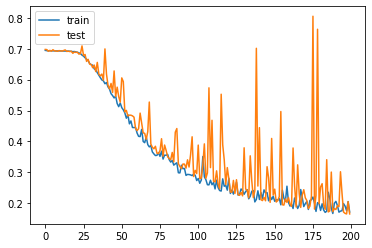

In [358]:
history_lstm_2 = LSTM_2.fit(X_train["lstm"][2], y_train[2], epochs=300, verbose=1, validation_data=(X_val["lstm"][2],y_val[2]), batch_size=batch_size)
plt.plot(history_lstm_2.history['loss'], label='train')
plt.plot(history_lstm_2.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 4016 samples, validate on 1004 samples
Epoch 1/300
4016/4016 [==============================] - 2s 382us/step - loss: 2.0732 - accuracy: 0.1474 - val_loss: 2.0340 - val_accuracy: 0.2191
Epoch 2/300
4016/4016 [==============================] - 1s 161us/step - loss: 2.0712 - accuracy: 0.1497 - val_loss: 2.0299 - val_accuracy: 0.1733
Epoch 3/300
4016/4016 [==============================] - 1s 161us/step - loss: 2.0706 - accuracy: 0.1504 - val_loss: 2.0345 - val_accuracy: 0.1733
Epoch 4/300
4016/4016 [==============================] - 1s 164us/step - loss: 2.0703 - accuracy: 0.1561 - val_loss: 2.0385 - val_accuracy: 0.2191
Epoch 5/300
4016/4016 [==============================] - 1s 163us/step - loss: 2.0699 - accuracy: 0.1531 - val_loss: 2.0338 - val_accuracy: 0.2191
Epoch 6/300
4016/4016 [==============================] - 1s 163us/step - loss: 2.0701 - accuracy: 0.1424 - val_loss: 2.0354 - val_accuracy: 0.2191
Epoch 7/300
4016/4016 [==============================] - 1s 162us/step

4016/4016 [==============================] - 1s 163us/step - loss: 2.0342 - accuracy: 0.1731 - val_loss: 2.0064 - val_accuracy: 0.2271
Epoch 57/300
4016/4016 [==============================] - 1s 161us/step - loss: 2.0241 - accuracy: 0.1795 - val_loss: 1.9945 - val_accuracy: 0.2281
Epoch 58/300
4016/4016 [==============================] - 1s 160us/step - loss: 2.0122 - accuracy: 0.1887 - val_loss: 1.9773 - val_accuracy: 0.2361
Epoch 59/300
4016/4016 [==============================] - 1s 186us/step - loss: 1.9939 - accuracy: 0.2117 - val_loss: 1.9752 - val_accuracy: 0.1962
Epoch 60/300
4016/4016 [==============================] - 1s 188us/step - loss: 1.9718 - accuracy: 0.2159 - val_loss: 1.9503 - val_accuracy: 0.2530
Epoch 61/300
4016/4016 [==============================] - 1s 166us/step - loss: 1.9447 - accuracy: 0.2485 - val_loss: 1.9214 - val_accuracy: 0.2540
Epoch 62/300
4016/4016 [==============================] - 1s 168us/step - loss: 1.9219 - accuracy: 0.2537 - val_loss: 1.9076 

4016/4016 [==============================] - 1s 159us/step - loss: 1.2842 - accuracy: 0.4771 - val_loss: 1.2658 - val_accuracy: 0.4542
Epoch 112/300
4016/4016 [==============================] - 1s 161us/step - loss: 1.2505 - accuracy: 0.4923 - val_loss: 1.2814 - val_accuracy: 0.5040
Epoch 113/300
4016/4016 [==============================] - 1s 159us/step - loss: 1.2591 - accuracy: 0.4928 - val_loss: 1.2205 - val_accuracy: 0.5627
Epoch 114/300
4016/4016 [==============================] - 1s 159us/step - loss: 1.2354 - accuracy: 0.5060 - val_loss: 1.2348 - val_accuracy: 0.5110
Epoch 115/300
4016/4016 [==============================] - 1s 159us/step - loss: 1.2256 - accuracy: 0.5105 - val_loss: 1.2387 - val_accuracy: 0.5408
Epoch 116/300
4016/4016 [==============================] - 1s 156us/step - loss: 1.2182 - accuracy: 0.5105 - val_loss: 1.2029 - val_accuracy: 0.5388
Epoch 117/300
4016/4016 [==============================] - 1s 158us/step - loss: 1.2211 - accuracy: 0.5065 - val_loss: 1

4016/4016 [==============================] - 1s 160us/step - loss: 0.8592 - accuracy: 0.6609 - val_loss: 0.9204 - val_accuracy: 0.6046
Epoch 167/300
4016/4016 [==============================] - 1s 159us/step - loss: 0.8546 - accuracy: 0.6599 - val_loss: 0.8414 - val_accuracy: 0.7151
Epoch 168/300
4016/4016 [==============================] - 1s 159us/step - loss: 0.8519 - accuracy: 0.6569 - val_loss: 0.9121 - val_accuracy: 0.6106
Epoch 169/300
4016/4016 [==============================] - 1s 161us/step - loss: 0.8307 - accuracy: 0.6863 - val_loss: 0.9834 - val_accuracy: 0.5488
Epoch 170/300
4016/4016 [==============================] - 1s 159us/step - loss: 0.8317 - accuracy: 0.6731 - val_loss: 0.9325 - val_accuracy: 0.5558
Epoch 171/300
4016/4016 [==============================] - 1s 159us/step - loss: 0.8496 - accuracy: 0.6487 - val_loss: 0.7937 - val_accuracy: 0.8396
Epoch 172/300
4016/4016 [==============================] - 1s 158us/step - loss: 0.8913 - accuracy: 0.6175 - val_loss: 0

4016/4016 [==============================] - 1s 159us/step - loss: 0.6970 - accuracy: 0.7363 - val_loss: 0.6483 - val_accuracy: 0.8177
Epoch 222/300
4016/4016 [==============================] - 1s 159us/step - loss: 0.7079 - accuracy: 0.7224 - val_loss: 0.6440 - val_accuracy: 0.8775
Epoch 223/300
4016/4016 [==============================] - 1s 160us/step - loss: 0.7216 - accuracy: 0.7298 - val_loss: 0.6702 - val_accuracy: 0.7659
Epoch 224/300
4016/4016 [==============================] - 1s 158us/step - loss: 0.7376 - accuracy: 0.6882 - val_loss: 0.6673 - val_accuracy: 0.7839
Epoch 225/300
4016/4016 [==============================] - 1s 158us/step - loss: 0.7529 - accuracy: 0.6683 - val_loss: 0.7276 - val_accuracy: 0.6873
Epoch 226/300
4016/4016 [==============================] - 1s 160us/step - loss: 0.6988 - accuracy: 0.7316 - val_loss: 0.7665 - val_accuracy: 0.6305
Epoch 227/300
4016/4016 [==============================] - 1s 161us/step - loss: 0.7091 - accuracy: 0.7154 - val_loss: 0

4016/4016 [==============================] - 1s 162us/step - loss: 0.6794 - accuracy: 0.7383 - val_loss: 0.5675 - val_accuracy: 0.8396
Epoch 277/300
4016/4016 [==============================] - 1s 165us/step - loss: 0.6869 - accuracy: 0.7176 - val_loss: 0.7906 - val_accuracy: 0.5627
Epoch 278/300
4016/4016 [==============================] - 1s 159us/step - loss: 0.6528 - accuracy: 0.7385 - val_loss: 0.5660 - val_accuracy: 0.8357
Epoch 279/300
4016/4016 [==============================] - 1s 163us/step - loss: 0.6438 - accuracy: 0.7652 - val_loss: 0.6344 - val_accuracy: 0.7231
Epoch 280/300
4016/4016 [==============================] - 1s 160us/step - loss: 0.6398 - accuracy: 0.7530 - val_loss: 0.6573 - val_accuracy: 0.7151
Epoch 281/300
4016/4016 [==============================] - 1s 158us/step - loss: 0.6726 - accuracy: 0.7234 - val_loss: 0.8499 - val_accuracy: 0.5239
Epoch 282/300
4016/4016 [==============================] - 1s 160us/step - loss: 0.6846 - accuracy: 0.7204 - val_loss: 0

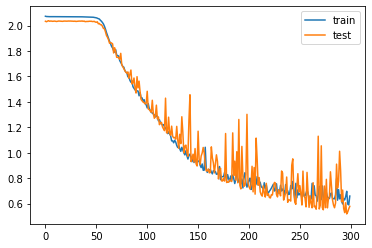

In [369]:
history_lstm_8 = LSTM_8.fit(X_train["lstm"][8], y_train[8], epochs=300, verbose=1, validation_data=(X_val["lstm"][8],y_val[8]), batch_size=batch_size)
plt.plot(history_lstm_8.history['loss'], label='train')
plt.plot(history_lstm_8.history['val_loss'], label='test')
plt.legend()
plt.show()